In [1]:
import json as json
import matplotlib.pyplot as plt
import os
import numpy as np

import multifil
import treatment_definitions as td
import graphing_utilities as gutil

# List valid things that can be changed
print("valid constant (phenotype) parameters\n", multifil.hs.hs.VALID_PARAMS)

imported myosin multifil
valid constant (phenotype) parameters
 ['mf_k', 'mh_c_ks', 'mh_c_kw', 'mh_c_rs', 'mh_c_rw', 'mh_g_ks', 'mh_g_kw', 'mh_g_rs', 'mh_g_rw', 'detachment_rate', 'mh_fd_k0', 'mh_fd_delta', 'af_k', 'ti_a', 'ti_b']


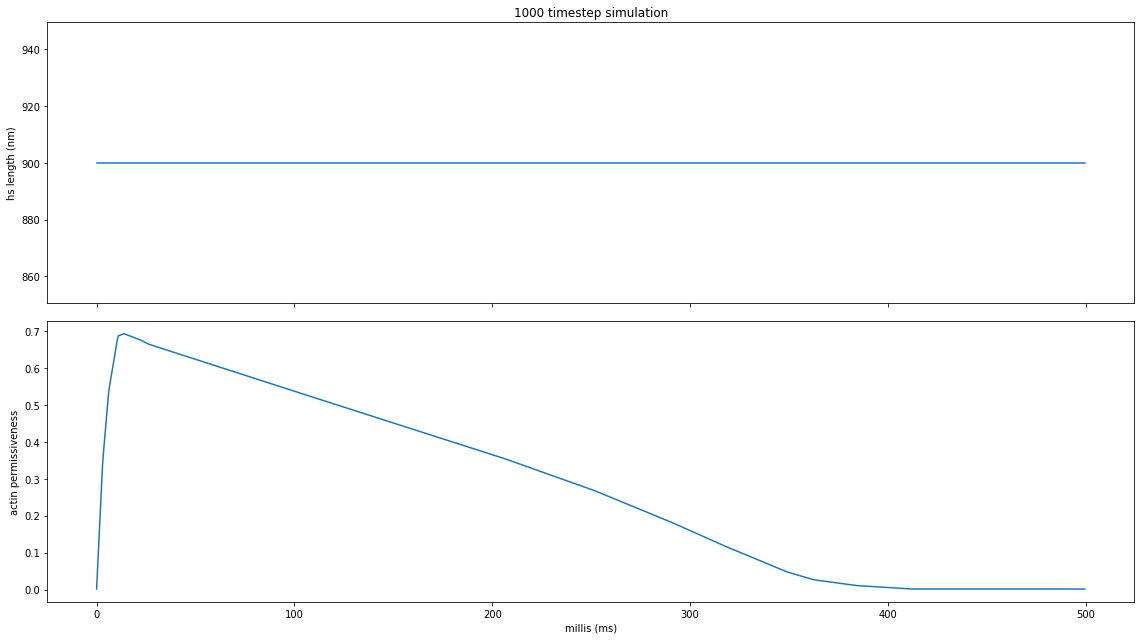

In [2]:
# choose stiffness
stiffness=40

# Setup experiment, show the traces
time_trace, length_trace, ap_trace, params = td.davis_t_spring(stiffness=stiffness)
comment = str(stiffness)

#plot the traces
gutil.plot_input_traces(time_trace, length_trace, ap_trace)

#print the phenotype settings


In [3]:
"""This code runs a single simulation"""
output_dir = "../_output/runClientOutput/"
os.makedirs(output_dir, exist_ok=True)

# check the comment to see what we are passing to it.
wl_meta = multifil.aws.metas.emit(
    path_local=output_dir,  # local dir to save run output to
    path_s3=None,  #s3 bucket to upload results to
    time=time_trace,
    poisson=0.0,  # poisson ratio, set to const lattice here
    ls=None,  # intial ls, using default by passing none
    z_line=length_trace, 
    actin_permissiveness=ap_trace,
    comment=comment,  # comment describing run
    hs_params=params,  # constants we want to alter - phenotype
    write=True,  # whether to write out resulting file or just pass back to variable
)

# determine where the metafile was saved.
run_name = wl_meta['name']
print(run_name)
run_file = output_dir + run_name + ".meta.json"

print(wl_meta['hs_params'])

run_manager = multifil.aws.run.manage(run_file, unattended=False) # have run.py create the sarc from meta
# Begin running
data, exit_code = run_manager.run_and_save()   # with our new sarc, run it, getting the data from it.

f5511e78-6a02-11ea-9713-185680feb82e
{'mh_c_ks': 40, 'mh_c_kw': 40}

MainProcess finished timestep 1 of 1000, 0h1m15s left

C:\Users\Anthony\Documents\github\fd_multifil\multifil\ti.py:184: UserWarning: Check radial force direction in titin
  warnings.warn("Check radial force direction in titin")



MainProcess finished timestep 101 of 1000, 0h3m40s left
MainProcess finished timestep 201 of 1000, 0h3m25s left
MainProcess finished timestep 301 of 1000, 0h3m4s left
MainProcess finished timestep 401 of 1000, 0h2m40s left
MainProcess finished timestep 501 of 1000, 0h2m19s left
MainProcess finished timestep 601 of 1000, 0h1m49s left
MainProcess finished timestep 701 of 1000, 0h1m19s left
MainProcess finished timestep 801 of 1000, 0h0m50s left
MainProcess finished timestep 901 of 1000, 0h0m23s leftrun.py MainProcess # ## model finished, uploading
run.py MainProcess # ## uploading finished, done with this run


saved to: ../_output/runClientOutput/\f5511e78-6a02-11ea-9713-185680feb82e.png


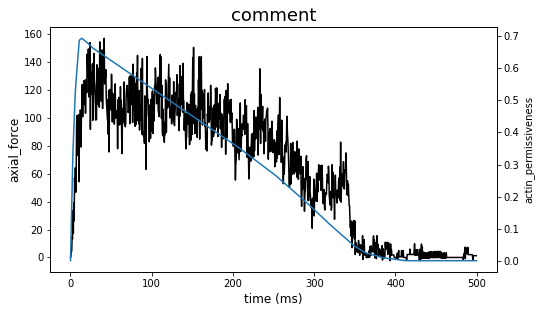

In [4]:
# graph the result
gutil.plot_data(data, title='comment', save_dir=output_dir)